# California Wildfires

![Smokey](images/smokey.jpg)

* Predict the size in acres of California wildfires using data from 2001 to 2018 (due to data availability)

## Goal

* Discover drivers of wildfire size
* Use drivers to develop a machine learning model to predict wildfire size
* This can hopefully be used to better prepare people for evacuation or farmers for some early harvesting (protect the vineyards)

## Imports

In [1]:
# local imports
import wrangle as w
import explore as e
import modeling as m

## Acquire

* Data acquired from Google BigQuery (EPA and USFS) and USDA
* Data initially acquired on 5 June 2023
* Dataset shapes before cleaning:
    * EPA: 32,888,162 rows, 29 columns
    * USFS: 22,985,028 rows, 348 columns
    * USDA: 2,303,566 rows, 39 columns
* Prebuilt dataset shape (already cleaned): 49026 rows, 26 columns
* Each row (after merge) represents a unique wildfire in California from 2001 to 2018 with averaged air quality data and most common tree species with averaged characteristics for the county the fire is located in
* Each column represents an element of the fire, tree species, or air quality

## Prepare

**Prepare Actions**:

* Renamed columns to promote readability and merging
* Removed columns
    - too many null values
    - related to target (fire_size_class)
    - duplicated information
    - too complex to explore for now
* Removed nulls
* Checked that column data types were appropriate
* Outliers of +1000 acres for fire size were removed
    - 1000 is considered a large wildfire in CA
* Created custom features
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/20/20)
* Scaled using Standard Scaler for modeling

In [2]:
# acquire, clean, and prepare the data
df = w.wrangle_wildfires()

# encode categorical columns
df = w.encode(df)

# split into train, validate, and test datasets
train, val, test = w.split_data(df)

#### A brief look at the data

In [3]:
train.head()

,date,time,cause_class,cause,fire_size,fire_size_class,lat,long,elevation_mean,county,...,most_common_is_hardwood,cause_class_human,cause_class_natural,cause_class_undetermined,six_cali_central_cali,six_cali_jefferson,six_cali_north_cali,six_cali_silicon_valley,six_cali_south_cali,six_cali_west_cali
42305,2017-06-19,652,natural,natural,0.1,a,35.435800,-115.698900,4768.292683,san bernardino,...,0,0,1,0,0,0,0,0,1,0
40689,2016-07-04,1713,undetermined,missing data/not specified/undetermined,0.1,a,33.781896,-116.995451,5819.402985,riverside,...,1,0,0,1,0,0,0,0,1,0
45649,2017-06-11,1505,undetermined,missing data/not specified/undetermined,0.5,b,37.018333,-119.668333,5830.731707,madera,...,0,0,0,1,1,0,0,0,0,0
15839,2006-07-09,1815,human,missing data/not specified/undetermined,1.0,b,34.375700,-118.516700,1900.000000,los angeles,...,1,1,0,0,0,0,0,0,0,1
21300,2007-04-07,2334,undetermined,missing data/not specified/undetermined,0.1,a,37.968052,-121.270813,2700.000000,san joaquin,...,1,0,0,1,1,0,0,0,0,0


#### Peek at target

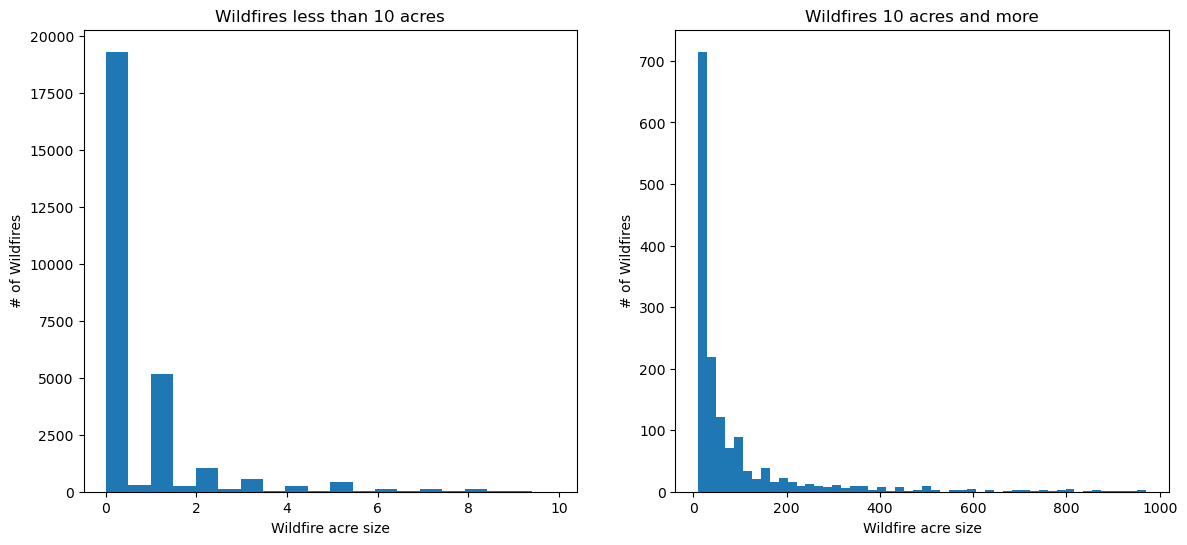

In [4]:
# pretty skewed to smaller fires, will handle better in another iteration
e.dist(train)

## Explore

* Is there a correlation between wind speed and fire size?
* Is there a correlation between relative humidity and fire size?
* Is there a correlation between outdoor temperature and fire size?
* Is there a correlation between average tree diameter and fire size?
* Is there a difference in the the average fire size among the types of wildfire causes?

### 1) Is there a correlation between wind speed and fire size?
* $H_0$: There is **NO** correlation between wind speed and fire size
* $H_a$: There is a correlation between wind direction and fire size
* Continuous (wind_speed_mean) vs Continuous (fire_size) = $Spearman's R$
    - $r$ = 0.021678812232446262
    - $p$ = 0.00020051319636766088
* `Wind speed` is correlated with `fire size`

Spearman's R: wind_speed_mean and fire_size
 r = 0.021678812232446262, p = 0.00020051319636766088


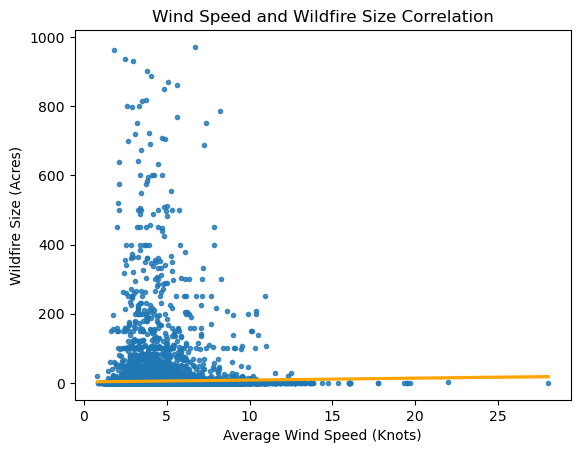

In [5]:
# wind speed barely correlated with fire size
e.wind_spd(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that wind speed and fire size are correlated with each other. I believe that using `wind_speed_mean` in the modeling could have a positive impact.**

### 2) Is there a correlation between relative humidity and fire size?
* $H_0$: There is **NO** correlation between relative humidity and fire size
* $H_a$: There is a correlation between relative humidity and fire size
* Continuous (humidity_mean) vs Continuous (fire_size) = $Spearman's R$
    - $r$ = -0.02058084267886851
    - $p$ = 0.0004155543747899636
* `Relative humidity` is negatively correlated with `fire size`

Spearman's R: humidity_mean and fire_size
 r = -0.02058084267886851, p = 0.0004155543747899636


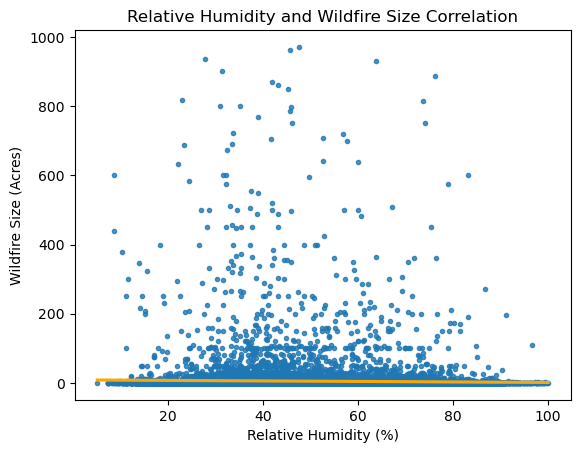

In [6]:
# relative humidity barely negatively correlated with fire size
e.humid(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that relative humidity and fire size are negatively correlated with each other. I believe that using `humidity_mean` in the modeling could have a positive impact.**

### 3) Is there a correlation between outdoor temperature and fire size?
* $H_0$: There is **NO** correlation between outdoor temperature and fire size
* $H_a$: There is a correlation between outdoor temperature and fire size
* Continuous (temp_mean) vs Continuous (fire_size) = $Spearman's R$
    - $r$ = 0.08005528978118515
    - $p$ = 4.98052207682677e-43
* `Outdoor temperature` is correlated with `fire size`

Spearman's R: temp_mean and fire_size
 r = 0.08005528978118515, p = 4.98052207682677e-43


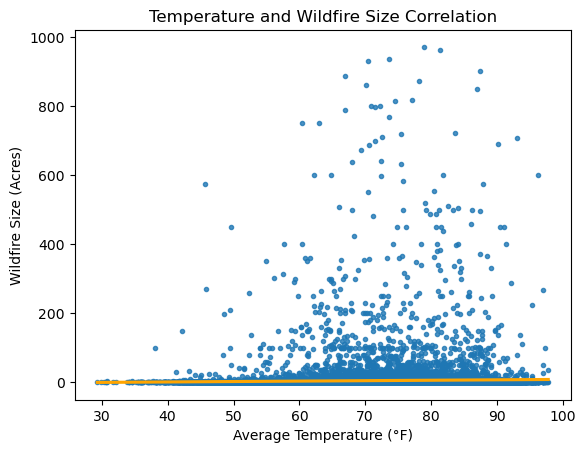

In [7]:
# outdoor temp correlated with fire size
e.temp(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that outdoor temperature and fire size are correlated with each other. I believe that using `temp_mean` in the modeling could have a positive impact.**

### 5) Is there a correlation between the average diameter of the trees and fire size?
* $H_0$: There is **NO** correlation between the average diameter of the trees and fire size
* $H_a$: There is a correlation between the average diameter of the trees and fire size
* Continuous (diameter_mean) vs Continuous (fire_size) = $Spearman's R$
    - $r$ = -0.005745458287828761
    - $p$ = 0.32444804813226613
* The `average diameter of the trees` is **NOT** correlated with `fire size`

Spearman's R: diameter_mean and fire_size
 r = -0.005745458287828761, p = 0.32444804813226613


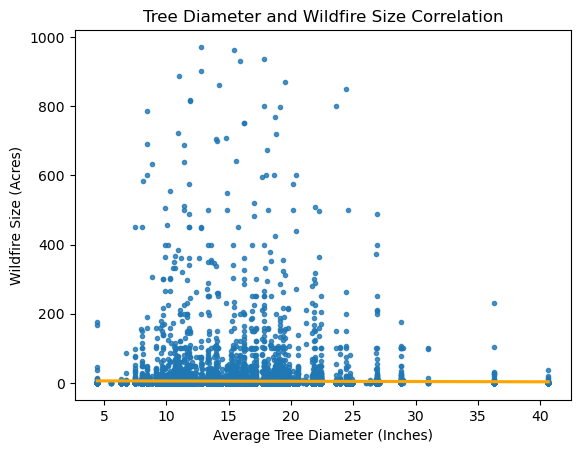

In [8]:
# average diameter of the trees not correlated with fire size
e.diameter(train)

**With an alpha of 0.05 (confidence 95%) the p-value is greater than alpha. Therefore, evidence suggests that the average diameter of trees and fire size are NOT correlated with each other. I believe that using `diameter_mean` in the modeling might not have a positive impact.**

### 5) Is there a difference in the the average fire size among the types of wildfire causes?
* $H_0$: There is **NO** difference in the average fire size
* $H_a$: There is a difference in the average fire size
* Discrete (cause_class) vs Continuous (fire_size) = $Kruskal$-$Wallis$ $H$
    - $H$ statistic = 267.6997997414239
    - $p$ = 7.408445371923476e-59
* There is a difference in `fire size` based on whether it was caused by a human, nature, or undetermined

Kruskal-Wallis H-Test:
 stat = 267.6997997414239, p = 7.408445371923476e-59


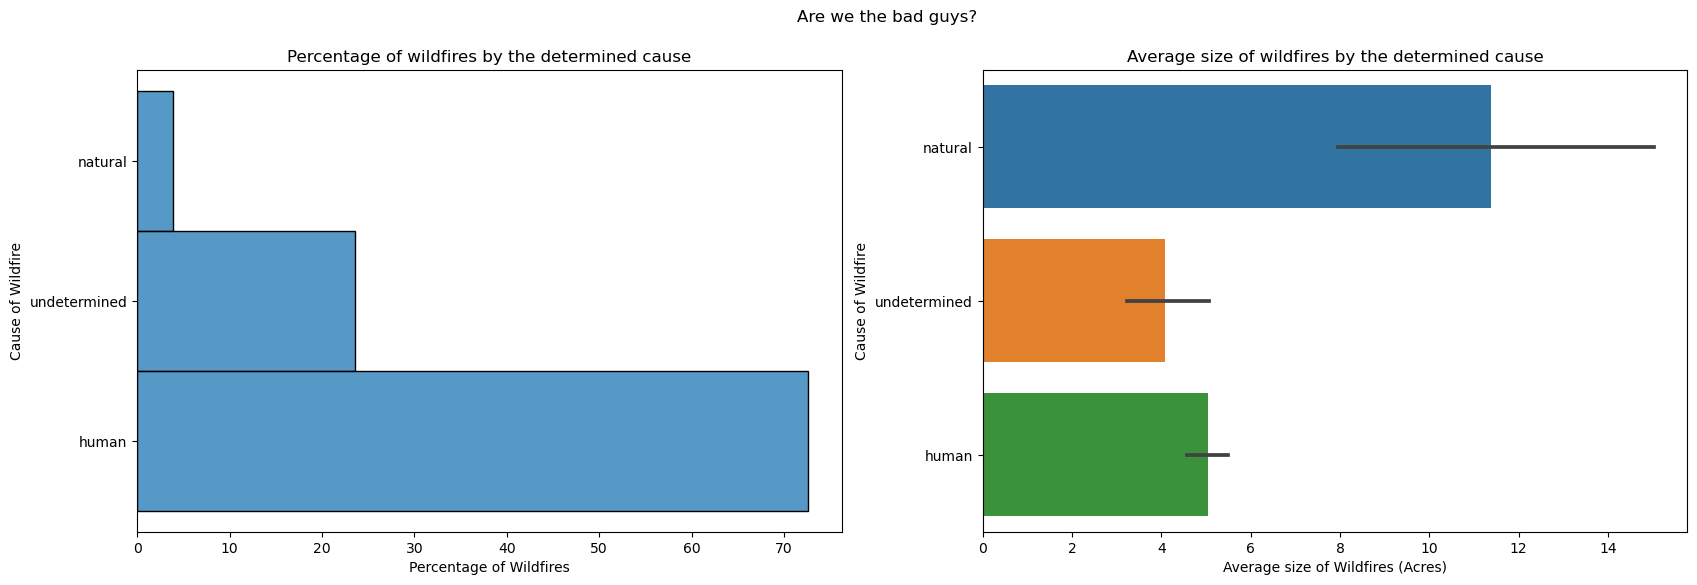

In [9]:
# how bad have humans been the cause of forest fires and fire size
e.bad_human(train)

It is easy to see on the left histplot that humans cause more fires while on the right barplot naturally caused fires burn more acres on average. 

#### How about acres burned between natural and human causes?

In [10]:
# it ain't pretty math but it shows humans have burned more acres in total
# count of human caused fires *times* avg size of human caused fires -minus- count of naturally caused fires *times* avg size of naturally caused fires
print(f"""How many acres have human caused fires burned more than nature? 
{round((train.cause_class=='human').sum()*train.groupby('cause_class').fire_size.mean().loc['human']-(train.cause_class=='natural').sum()*train.groupby('cause_class').fire_size.mean().loc['natural'],2)} acres
""")

How many acres have human caused fires burned more than nature? 
94733.76 acres



What is interesting though is that humans have burned more acres in total by over 90k acres (just train data, not including outliers) than natural fires.

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that there is a difference in fire size based on the cause of a fire. I believe that using `cause_class` in the modeling could have a positive impact but since we probably won't know the cause until after the fact I will not use it in the model.**


## Exploration Summary
* Humans have caused a lot of fire damage (humans probably should not have discovered fire)
* Outdoor temperature is the most correlated of the these
* While outdoor temperature, wind speed, and relative humidity are correlated, the amount is still small and may help in modeling but probably not by much
* Average tree diameter is not correlated with fire size

### Features for modeling
* Features that will be used:
    - fire_size (target)
* Some features that may be useful:
    - wind_speed_mean
    - humidity_mean
    - temp_mean
* Features I will not use:
    - fire_size_class (directly related to the target)
    - cause_class (we might not know the cause until after the fire happens)
    - diameter_mean

## Modeling

* $RMSE$ and $R^2$ will be the evaluation metrics
* Target feature is fire_size
* Using the mean of the wildfire size as the baseline
    - 5.06 acres will be the baseline wildfire size
* Features scaled using Standard Scaler
* Models will be developed and evaluated using a few different model types, various features, and various hyperparameter configurations
    - Linear Regression
    - Polynomial Features through Linear Regression
    - Lasso Lars
    - Tweedie Regressor
* Models will be evaluated on train and validate datasets
* Best performing model will be the only one evaluated on the test dataset

In [11]:
# split into X and y
X_train,X_val,X_test = train.drop(columns=['fire_size','fire_size_class','date']),val.drop(columns=['fire_size','fire_size_class','date']),test.drop(columns=['fire_size','fire_size_class','date'])
y_train,y_val,y_test = train[['fire_size']],val[['fire_size']],test[['fire_size']]

# Standard Scaler
Xs_train,Xs_val,Xs_test = w.std(X_train,X_val,X_test,X_train.select_dtypes(exclude='object').columns)

In [12]:
# get baseline accuracy
m.baseline(y_train,y_val)

Baseline Fire Size: 5.06
Train       RMSE: 37.076012445750536   R2: 0.0
Validate    RMSE: 45.150785048157346    R2: -0.00018417621236865855


### Best of 4 Model Configurations

#### Linear Regression

In [13]:
# get linear regression results
m.final_model('lr',Xs_train,y_train,Xs_val,y_val)

Linear Regression
Train       RMSE: 37.03   R2: 0.0026
Validate    RMSE: 45.08    R2: 0.0028


#### Polynomial Features through Linear Regression

In [14]:
# get polynomial feature results
m.final_model('poly',Xs_train,y_train,Xs_val,y_val)

Polynomial Features through Linear Regression
Train       RMSE: 36.98   R2: 0.0053
Validate    RMSE: 45.05    R2: 0.0042


#### Lasso Lars

In [15]:
# get lasso lars results
m.final_model('lasso',Xs_train,y_train,Xs_val,y_val)

Lasso Lars
Train       RMSE: 37.06   R2: 0.0007
Validate    RMSE: 45.14    R2: 0.0003


#### Tweedie Regressor

In [16]:
# get tweedie results
m.final_model('tweedie',Xs_train,y_train,Xs_val,y_val)

Lasso Lars
Train       RMSE: 37.04   R2: 0.002
Validate    RMSE: 45.11    R2: 0.0015


### Best on Test
* Polynomial Features

In [17]:
# get test results for final model
m.test_model(Xs_train,y_train,Xs_test,y_test)

Polynomial Features through Linear Regression
Test    RMSE: 42.14    R2: 0.0041


#### How does it compare?

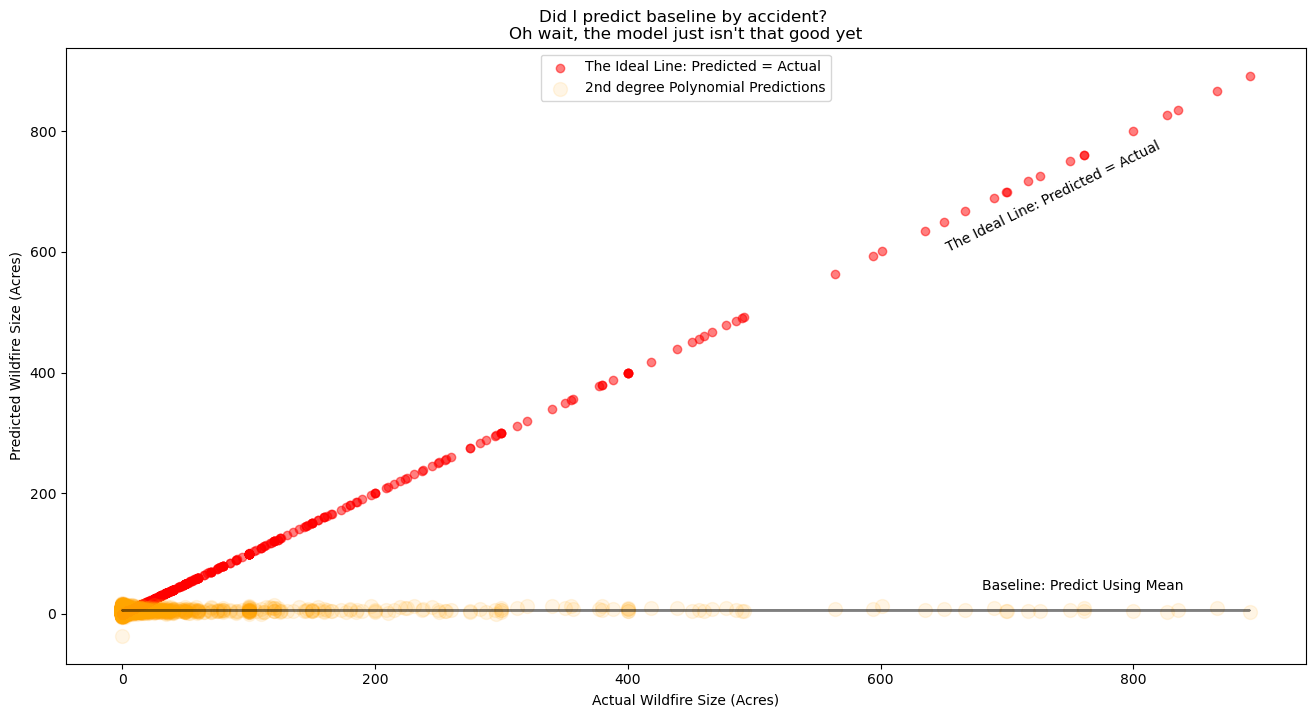

In [18]:
# plot predictions vs actual of test
m.plt_err(Xs_train,y_train,Xs_test,y_test)

### Modeling Wrap Up
- It looks more like I predicted close to baseline than predicting the actual fire sizes
- Polynomial seemed to work best (just barely)
- Model was better then baseline but not significantly so, and can use improvement
- Lasso only used 2 features (temperature and humidity) and was close to being the best
    - it could be considered best for using least amount of info but still predicting a better than baseline RMSE
- Polynomial used the same 2 features plus 5 more and just barely beats Lasso


## Conclusion

### Takeaways and Key Findings
* Outdoor temperature is the most correlated (hot temps, dry days, hot fires)
* While outdoor temperature, wind speed, and relative humidity are correlated, the amount is still small and may help in modeling but probably not by much
* Average tree diameter is not correlated with fire size
* Human caused wildfires accounted for more than 70% of them and while not burning as many acres on average as nature has it still burned more acres in total
* Model was better then baseline but not significantly so, and can use improvement
  - It does predict a few acres closer the true fire sizes but not enough to make a major difference

### Recommendations and Next Steps
* I would suggest we try to get global warming under control as more and bigger fires are happening each year due to increased temperatures
* *Smokey the bear*: "Only you can prevent wildfires" 🐻👉🚫🔥🌲
* When out and about in the world, be careful when dealing with anything that can spark, give off heat, or be flammable
* Given more time I would:
  * use more air quality data for California
  * maybe not include forest data
  * handle nulls in a way other than just dropping
  * focus more on larger fires so that data is not skewed to tiny fires
  * look at the west coast states of the US or all of the states (maybe even include Canada)
  * find a better way to more accurately merge the data, maybe even try some clustering techniques to find the 'hot zones' based on location
  * take a look at the number of wildfires and sizes with a time-series approach
  * build better models, maybe even make models for each of the fire size classifications (A-G)

![Smokey again](images/smokey2.jpg)